In [67]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import albumentations as A
import numpy as np
import keras
import glob
import cv2
import os

'''
todo: just check the scaling from int16 -> unit16 on the vilsualization
also changed the max value in augmentation from 65,535 -> 1 as robust scaler.
filter hieghts and settlement map together to be one thing
mask stailte  images to settlement map 
predicitions visualize only scale the visualized rgb and keep it normal for preds
create my own error metric maybe loss

'''

'\ntodo: just check the scaling from int16 -> unit16 on the vilsualization\nalso changed the max value in augmentation from 65,535 -> 1 as robust scaler.\nfilter hieghts and settlement map together to be one thing\nmask stailte  images to settlement map \npredicitions visualize only scale the visualized rgb and keep it normal for preds\ncreate my own error metric maybe loss\n\n'

In [68]:
class DataGenerator(keras.utils.Sequence):

    
    def __init__(self, augmentations='', visualize=False, batch_size=5, dim=(250,250), 
                 dim_pad=(256,256), X_n_channels=17, shuffle=True, y_n_channels=1, train=True,
                 
                 X_train_dir='C:/Users/egnke/PythonCode/Met_Eireann_git/Ireland_building_heights/Modelling/DataSetCreation/Unet-Data/X_train/',
                 y_train_dir='C:/Users/egnke/PythonCode/Met_Eireann_git/Ireland_building_heights/Modelling/DataSetCreation/Unet-Data/Y_train/',
                 
                 X_test_dir='C:/Users/egnke/PythonCode/Met_Eireann_git/Ireland_building_heights/Modelling/DataSetCreation/Unet-Data/X_test/',
                 y_test_dir='C:/Users/egnke/PythonCode/Met_Eireann_git/Ireland_building_heights/Modelling/DataSetCreation/Unet-Data/Y_test/',
                
                ):
        
        # this is the dim before padding
        
        self.dim = dim
        self.dim_pad = dim_pad
        self.visualize = visualize
        self.batch_size = batch_size
        self.X_n_channels = X_n_channels
        self.y_n_channels = y_n_channels
        self.shuffle = shuffle
        self.train = train
        
        if self.train:
            self.X_dir = X_train_dir
            self.y_dir = y_train_dir
            self.list_IDs = self.read_in_list_of_ids(X_train_dir)
        
        else:
            self.X_dir = X_test_dir
            self.y_dir = y_test_dir
            self.list_IDs = self.read_in_list_of_ids(X_test_dir)
        
        self.augment = augmentations
        self.on_epoch_end()

        
    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    
    def __getitem__(self, index):
        '''Generate one batch of data'''
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    
    def on_epoch_end(self):
        '''Updates indexes after each epoch'''
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X_no_pad = np.empty((self.batch_size, *self.dim, self.X_n_channels))
        y_no_pad = np.empty((self.batch_size, *self.dim, self.y_n_channels))
        
        X = np.empty((self.batch_size, *self.dim_pad, self.X_n_channels))
        y = np.empty((self.batch_size, *self.dim_pad, self.y_n_channels))
        

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            # Store sample
            temp_x = np.load(self.X_dir + 'X_' + ID)

            # convert from int16 -32,768 to 32,767 -> uint16 0 to 65,535
            if self.visualize:
                # min max good for vizuals but scales each image from its on min and max values.
                # as our values are reflectnce values these number mattter globaly.
                temp_x = np.where(temp_x==-9999, -99, temp_x)
                #X_no_pad[i,] = cv2.normalize(temp_x, None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX)
                X_no_pad[i,] = self.normalize_image(temp_x)
            
            else:
                X_no_pad[i,] = self.convert_int16_to_uint_16(temp_x)
                
                
            # Store class
            temp_y = np.load(self.y_dir + 'Y_' + ID)

            # replace missing values with a height of 0 
            y_no_pad[i,] = np.where(temp_y==-32767.0, 0, temp_y) 
        
            if self.augment:

                augmented = self.augment(image=X_no_pad[i,], mask=y_no_pad[i,])
                X_no_pad[i,] = augmented['image']
                y_no_pad[i,] = augmented['mask']
        
        
            # regardless of augmetation or visualization 
            # padding image from 250x250x3 -> 256x256x3
            
            X[i,] = self.zero_pad_img_250_256(X_no_pad[i,])
            y[i,] = self.zero_pad_img_250_256(y_no_pad[i,])
            
            
        return X, y
    
    
    @staticmethod
    def read_in_list_of_ids(directory):
        '''
        the format of image names is as follows for both X and Y X/Y_TileId_X1_X2_Y1_Y2.npy
        create a list from either directory as follows _TileId_X1_X2_Y1_Y2.npy
        so that we can shuffle and select image pairs in the image generator.
        '''
        list_of_ids = []

        for filepath in glob.glob(directory + '*.npy'):
            filename = filepath.split('\\')[1]
            parsed_filename = '_'.join(filename.split('_')[1:])
            list_of_ids.append(parsed_filename)

        return list_of_ids
    
    
    @staticmethod
    def convert_int16_to_uint_16(img_int16):
        '''
        convert an image from int16 range -32768, 32767
        to the uint range of 0, 65535 as this is required for
        the albumentations library to work. 
        '''

        int16 = np.arange(-32768, 32767)
        uint16 = np.arange(0, 65535)
        int16_to_uint16 = dict(zip(int16, uint16))

        img_uint16 = np.vectorize(int16_to_uint16.get)(img_int16)

        return img_uint16
    
    
    @staticmethod
    def zero_pad_img_250_256(img, before_after_axis=((3, 3), (3, 3), (0, 0))):
        '''
        zero pad numpy array default will pad 250x250x3 -> 256x256x3
        each tuple in tuple refers to an axis ((3,3),(3,3),(0,0))
        so if we wanted to convert a 250x250x250x3 -> 256x256x256x3
        we would write ((3,3),(3,3),(3,3),(0,0))
        '''
        
        padded_img = np.pad(img, before_after_axis, 
                            mode='constant', constant_values=0)
        return padded_img
    
    
    @staticmethod
    def normalize_image(img, scaler=MinMaxScaler()):
        '''
        normalize image pixels between 0-1 for visualization purposes
        sklearn saclers image 250x250 is interpreted as 250 columns so 
        each column will be normalized indivdually leaving a gridline effect.
        Thats why we have to reshape our data.

        ignores last column as this is the binary settlement map.

        see https://stackoverflow.com/questions/37751717/why-does-minmaxscaler-add-lines-to-image
        '''

        channels = img.shape[-1]
        settlement_map = img[:,:,-1]
        
        as_columns = img.reshape(-1, channels)
        normalized_as_cols = scaler.fit_transform(as_columns)
        transformed_img = normalized_as_cols.reshape(img.shape)
        transformed_img[:,:,-1] = settlement_map

        return transformed_img




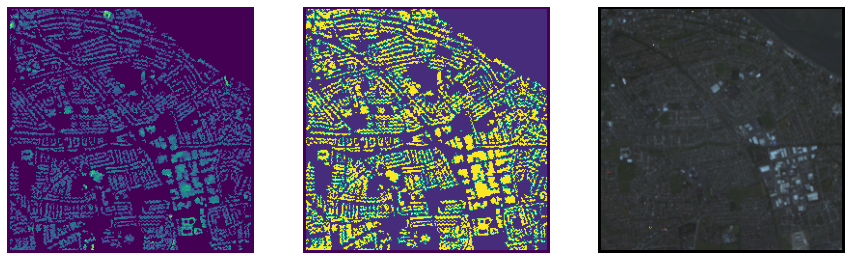

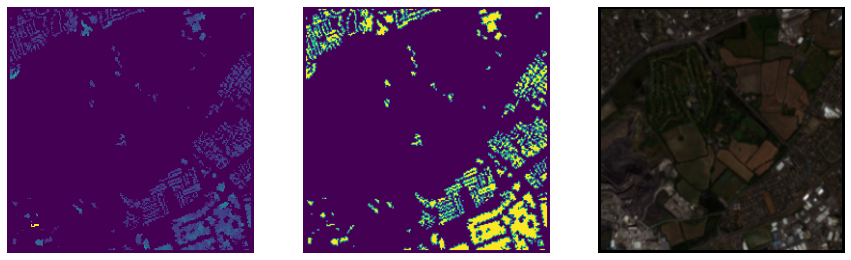

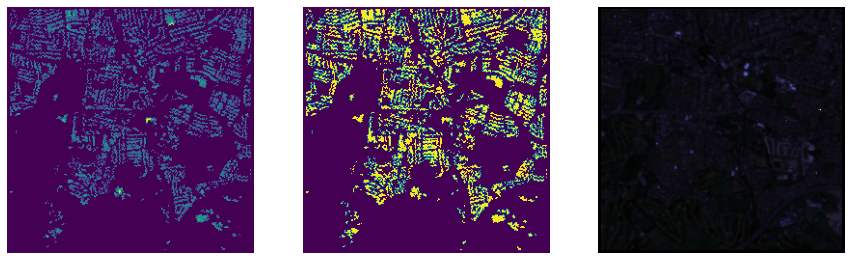

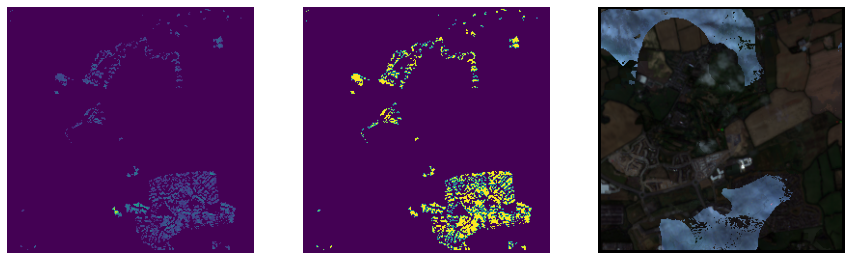

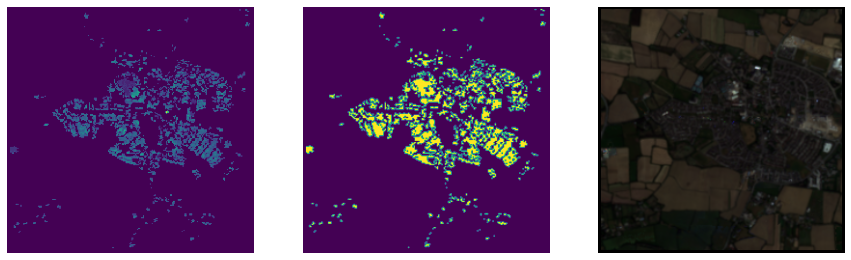

In [69]:
def create_rgb_scene(image, r=10, g=2, b=0):
    
    # convert from bgr to rgb
    width = image.shape[0]
    height = image.shape[1]
    channel = 3
    
    img_rgb = np.empty((*(width,height), channel))
    img_rgb[:,:,0] = image[:,:,r]
    img_rgb[:,:,1] = image[:,:,g]
    img_rgb[:,:,2] = image[:,:,b]
    
    return img_rgb
    
    
def visulaize(train=True):
    
    augmentations_visualize = A.Compose([
    
        # need to convert uint (0,65535) -> float (0-1)
        #A.ToFloat(max_value=65535.0),
        A.ToFloat(1),

        # spatial transforms
        A.RandomResizedCrop(width=250, height=250, p=0.2),
        A.HorizontalFlip(p=0.25),
        A.VerticalFlip(p=0.25),
        A.RandomRotate90(p=0.25),
        A.ShiftScaleRotate(p=0.25),

        # pixel distortions
        A.RandomBrightnessContrast(p=0.2),
        A.RandomBrightness(p=0.2),
        A.RandomGamma(p=0.2),

    ])
    
    data = DataGenerator(augmentations=augmentations_visualize, visualize=True, train=train).__getitem__(1)
    
    for i in range(len(data[0])):
        
        X = data[0][i]
        y = data[1][i]

        rgb_image = create_rgb_scene(X)
        settlement_image = X[:,:,-1]
        height_image = y

        fig = plt.figure(figsize=(15, 15))
        ax1 = fig.add_subplot(1,3,1)
        ax1.axis('off')
        ax1.imshow(height_image)
        
        ax2 = fig.add_subplot(1,3,2)
        ax2.axis('off')
        ax2.imshow(settlement_image)

        ax3 = fig.add_subplot(1,3,3)
        ax3.axis('off')
        ax3.imshow(rgb_image)
    

augmentations_train = A.Compose([
    
    # need to convert uint (0,65535) -> float (0-1)
    A.ToFloat(max_value=65535.0),
    
    # spatial transforms
    A.RandomResizedCrop(width=250, height=250, p=0.2),
    A.HorizontalFlip(p=0.25),
    A.VerticalFlip(p=0.25),
    A.RandomRotate90(p=0.25),
    A.ShiftScaleRotate(p=0.25),
    
    # pixel distortions
    A.RandomBrightnessContrast(p=0.2),
    A.RandomBrightness(p=0.2),
    A.RandomGamma(p=0.2),
    
    ])


augmentations_test = A.Compose([
    
    # need to convert uint (0,65535) -> float (0-1)
    A.ToFloat(max_value=65535.0),
    
    ])
    
    
visulaize(train=True)

# Unet-Model

In [70]:
def se_block(in_block, ch, ratio=16):
    
    x = keras.layers.GlobalAveragePooling2D()(in_block)
    x = keras.layers.Dense(ch//ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(x)
    x = keras.layers.Dense(ch, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(x)
    
    return keras.layers.Multiply()([in_block, x])



def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    '''
    Down Covolutional block of unet
    '''
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding,
                            strides=strides, activation="relu")(x)
    
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding,
                            strides=strides, activation="relu")(c)
    
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    
    # apply squeze excite block
    c = se_block(c, filters)
    
    return c, p



def up_block(x, skip, se, filters, kernel_size=(3, 3), padding="same", strides=1):
    '''
    Up Covolutional block of unet
    '''
    us = keras.layers.UpSampling2D((2, 2))(x)
    se = keras.layers.UpSampling2D((2, 2))(se)

    conact_squeeze = keras.layers.Concatenate()([skip, se])
    concat = keras.layers.Concatenate()([us, conact_squeeze])
    
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding,
                            strides=strides, activation="relu")(concat)
    
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding,
                            strides=strides, activation="relu")(c)
    
    # apply squeze excite block
    se = se_block(c, filters)
    
    return c, se


def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    '''
    the bottle neck in unet that joins down convolutional and up convolutional
    blocks.
    '''
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding,
                            strides=strides, activation="relu")(x)
    
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding,
                            strides=strides, activation="relu")(c)
    
    # apply squeze excite block
    se = se_block(c, filters)
    
    return c, se



def UNet(input_size=(256,256,3)):
    '''
    defining the unet model architecture
    '''
    
    layer_nodes = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input(input_size)
    
    p0 = inputs
    # encoder
    c1, p1 = down_block(p0, layer_nodes[0]) #128 -> 64
    c2, p2 = down_block(p1, layer_nodes[1]) #64 -> 32
    c3, p3 = down_block(p2, layer_nodes[2]) #32 -> 16
    c4, p4 = down_block(p3, layer_nodes[3]) #16->8
    
    # bottleneck
    bn, se0 = bottleneck(p4, layer_nodes[4])
    
    # decoder
    u1, se1 = up_block(bn, c4, se0, layer_nodes[3]) #8 -> 16
    u2, se2 = up_block(u1, c3, se1, layer_nodes[2]) #16 -> 32
    u3, se3 = up_block(u2, c2, se2, layer_nodes[1]) #32 -> 64
    u4, se4 = up_block(u3, c1, se3, layer_nodes[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="relu")(se4)
    model = keras.models.Model(inputs, outputs)
    
    return model

In [71]:
'''
def weighted_root_mean_squared_error(y_true, y_pred):
    
    def replace_value_with_frequency_of_occurance(array):
       
        converts the values to their frequncy of apperance
        [1,2,3,1,2] -> [2,2,1,2,2]
       
        
        y, idx, count = tf.unique_with_counts(x)
        unique_elements, counts_elements = np.unique(array, return_counts=True)
        mapping = dict(zip(unique_elements, counts_elements))

        frequencies = np.vectorize(mapping.get)(array)
        return tf.convert_to_tensor(frequencies)
    
    y_pred = tf.where(y_true > 0, y_pred, 0)
    weights = replace_value_with_frequency_of_occurance(y_true)
    
    return tf.sqrt(tf.sum(weights * ((y_pred - y_true) ** 2)) / tf.sum(weights))
'''


from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    y_pred = tf.where(y_true > 0, y_pred, 0)
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 




image_size = 256

training_generator = DataGenerator(augmentations=augmentations_train, train=True, visualize=False)
testing_generator  = DataGenerator(augmentations=augmentations_test,  train=False, visualize=False)

unet_model = UNet(input_size=(256,256,17))
unet_model.compile(optimizer='adam', loss=root_mean_squared_error, metrics=['mse'])
#unet_model.compile(optimizer='adam', loss='mean_squared_logarithmic_error', metrics=['mse'])
unet_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 256, 256, 17 0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 256, 256, 16) 2464        input_19[0][0]                   
__________________________________________________________________________________________________
conv2d_190 (Conv2D)             (None, 256, 256, 16) 2320        conv2d_189[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_58 (MaxPooling2D) (None, 128, 128, 16) 0           conv2d_190[0][0]                 
____________________________________________________________________________________________

In [72]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

unet_model.fit(
            training_generator,
            epochs=100,
            validation_data=testing_generator,
            workers=2, use_multiprocessing=False,
            callbacks=[callback]
)


Epoch 1/100
48/48 [==============================] - 220s 4s/step - loss: 3.0783 - mse: 60.1901 - val_loss: 0.8912 - val_mse: 35.9908
Epoch 2/100
48/48 [==============================] - 201s 4s/step - loss: 1.5324 - mse: 40.5390 - val_loss: 0.8820 - val_mse: 34.0631
Epoch 3/100
48/48 [==============================] - 198s 4s/step - loss: 1.4712 - mse: 43.1100 - val_loss: 0.8832 - val_mse: 34.0080
Epoch 4/100
48/48 [==============================] - 200s 4s/step - loss: 1.5188 - mse: 43.8397 - val_loss: 0.9120 - val_mse: 43.4930
Epoch 5/100
48/48 [==============================] - 200s 4s/step - loss: 1.4888 - mse: 45.8783 - val_loss: 0.9630 - val_mse: 48.0166
Epoch 6/100
48/48 [==============================] - 198s 4s/step - loss: 1.4832 - mse: 44.4209 - val_loss: 0.9327 - val_mse: 28.7130
Epoch 7/100
48/48 [==============================] - 200s 4s/step - loss: 1.5757 - mse: 42.9030 - val_loss: 0.9004 - val_mse: 42.2252


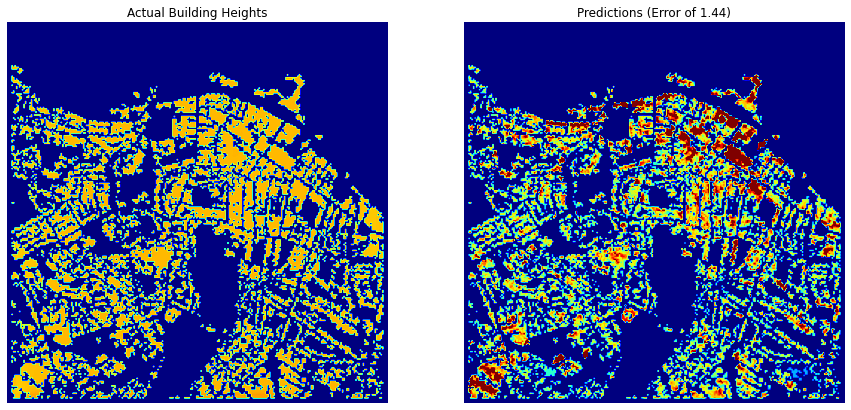

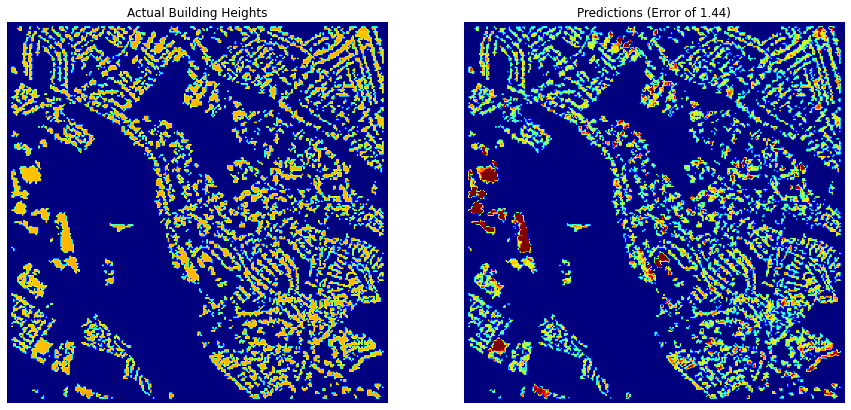

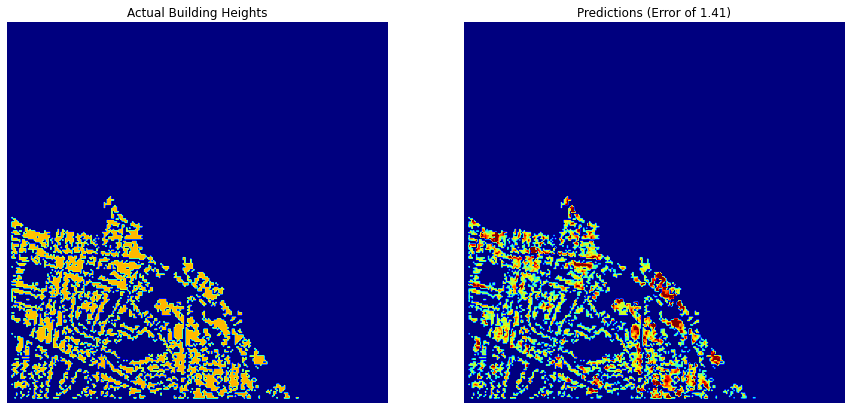

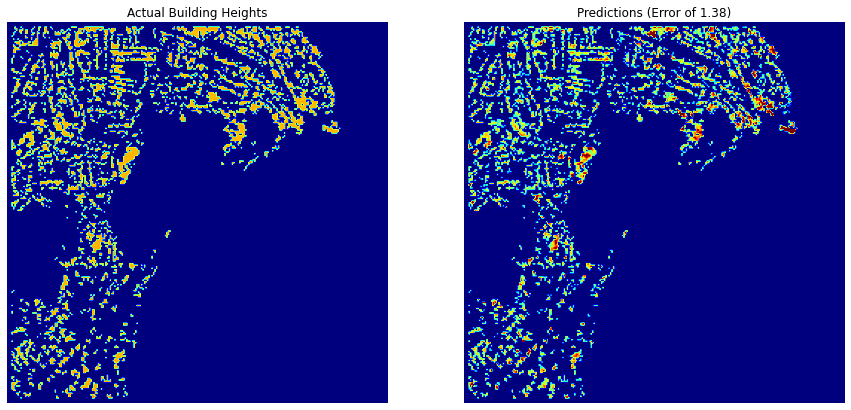

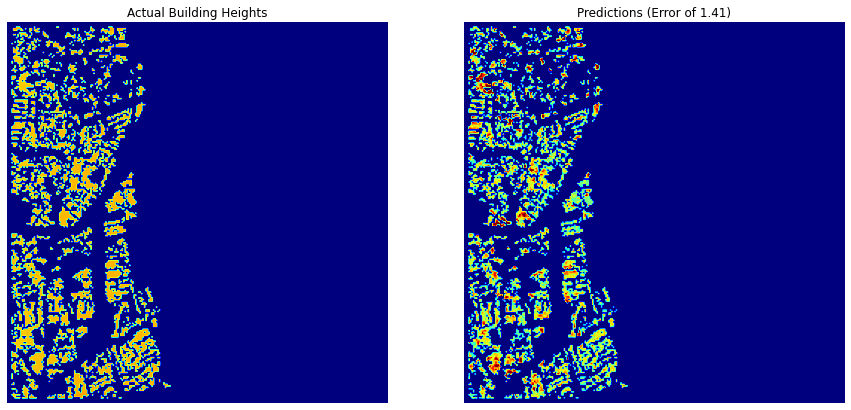

In [80]:
def replace_value_with_frequency_of_occurance(array):

    unique_elements, counts_elements = np.unique(array, return_counts=True)
    mapping = dict(zip(unique_elements, counts_elements))
    
    return np.vectorize(mapping.get)(array)


def weighted_root_mean_squared_error(y_actual, y_pred):
    
    y_actual = y_actual.flatten()
    y_pred   = y_pred.flatten()

    y_actual = y_actual[y_actual > 0]
    y_pred   = y_pred[y_pred > 0]
    
    weights = replace_value_with_frequency_of_occurance(y_actual)
    return np.sqrt(np.sum(weights * ((y_pred - y_actual) ** 2)) / np.sum(weights))


def visulaize_predictions(model):
    
    augmentations_visualize = A.Compose([
    
        # need to convert uint (0,65535) -> float (0-1)
        A.ToFloat(max_value=65535.0),
        #A.ToFloat(1),

    ])
    
    data  = DataGenerator(augmentations=augmentations_visualize, train=False, visualize=False).__getitem__(1)
    preds = model.predict(data[0])
    
    for i in range(len(data[0])):
    
        X = data[0][i]
        y = data[1][i]
        
        pred = preds[i]
        rgb_image = create_rgb_scene(X)
        height_image = y
        
        masked_preds = np.where(height_image > 0, pred, 0)

        fig = plt.figure(figsize=(15, 15))

        error = round(weighted_root_mean_squared_error(height_image, masked_preds),2)
        ax1 = fig.add_subplot(1,2,1)
        ax1.axis('off')
        ax1.set_title("Actual Building Heights")
        ax1.imshow(masked_preds, vmin=0, vmax=10, cmap='jet')
        
        ax2 = fig.add_subplot(1,2,2)
        ax2.axis('off')
        ax2.set_title(f"Predictions (Error of {error})")
        ax2.imshow(height_image, vmin=0, vmax=10, cmap='jet')


        
        
visulaize_predictions(model=unet_model)

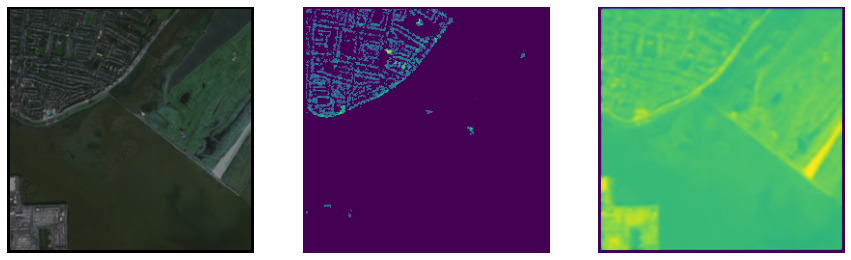

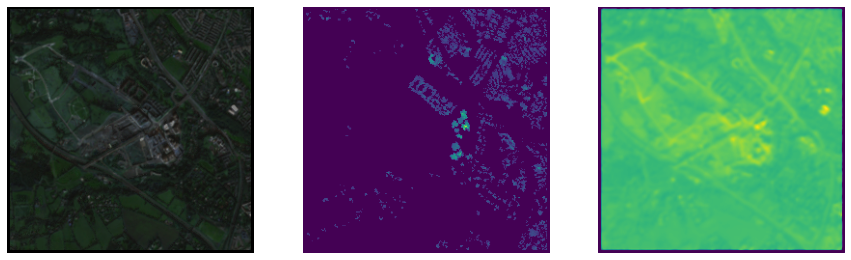

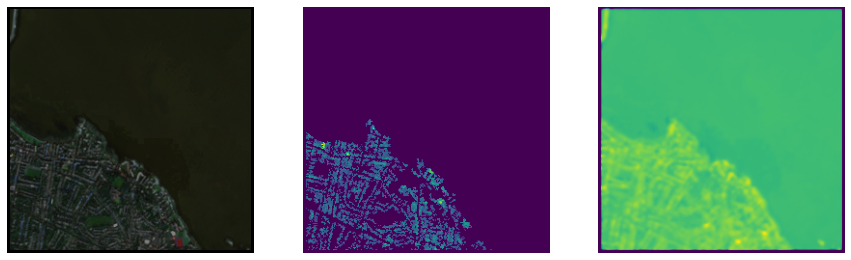

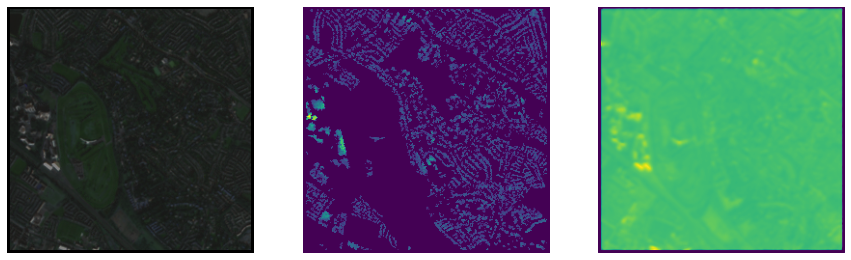

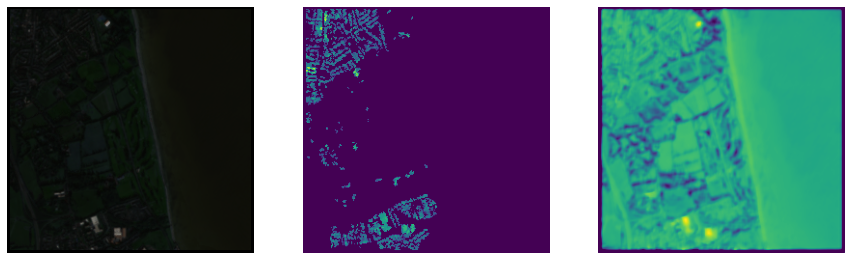

In [215]:
def visulaize_predictions(model):
    
    augmentations_visualize = A.Compose([
    
        # need to convert uint (0,65535) -> float (0-1)
        #A.ToFloat(max_value=65535.0),
        A.ToFloat(1),

    ])
    
    data  = DataGenerator(augmentations=augmentations_visualize, train=False, visualize=True).__getitem__(1)
    preds = model.predict(data[0])
    
    for i in range(len(data[0])):
    
        X = data[0][i]
        y = data[1][i]
        
        pred = preds[i]
        rgb_image = create_rgb_scene(X)
        height_image = y

        fig = plt.figure(figsize=(15, 15))
        
        ax1 = fig.add_subplot(1,3,1)
        ax1.axis('off')
        ax1.imshow(rgb_image)
        
        ax2 = fig.add_subplot(1,3,2)
        ax2.axis('off')
        ax2.imshow(height_image)

        ax3 = fig.add_subplot(1,3,3)
        ax3.axis('off')
        ax3.imshow(pred)
        
        
visulaize_predictions(model=unet_model)

In [ ]:
unet_model.save_weights('rgb_model_weights.hdf5')